基于auto-apt-0312，增加实验次数，对结果求平均

In [1]:
# 挂载google云盘
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cat /proc/cpuinfo | grep model\ name

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/multi-step-attack/"
# path = "./"

**自动关联APT**\
1.维护一个history vector，对新来的new vector做分类\
2.sum polling history vector\
3.加入attention机制

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import gensim
from gensim.models import Word2Vec
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import time

## load data,preprocess

In [0]:
class DataLoader:
    '''
    load data;preprocess;embedding;split;time step
    '''
    def __init__(self):
        pass

    def load_data(self,path):
        data = pd.read_csv(path)
        return data
    
    def processing_data(self,data):
        '''
        连续变量对数变换离散化
        '''
        data['Length'] = np.log(data['Length']+0.000001)
        data['delta_time'] = np.log(data['delta_time']+0.000001)
#         data['Length'] = data['Length']-data['Length'].mean()/data['Length'].std()
        data['Length'] = (data['Length']-data['Length'].min())/(data['Length'].max()-data['Length'].min())
#         data['delta_time'] = data['delta_time']-data['delta_time'].mean()/data['delta_time'].std()
        data['delta_time'] = (data['delta_time']-data['delta_time'].min())/(data['delta_time'].max()-data['delta_time'].min())

        data['cat_Length'] = pd.cut(data['Length'].astype('int'),10,labels=False)
        data['cat_delta_time'] = pd.cut(data['delta_time'].astype('float'),10,labels=False)
        
        data = data[["." in Source for Source in data.Source]]

        return data

    def feature_select(self,data):
        '''
        ip 特征构建；port 映射
        '''
        times = 20

        ## ip embedding；ip str to int
        data['sip_1'] = data['Source'].apply(lambda x:x.split('.')[0])
        data['sip_2'] = data['Source'].apply(lambda x:x.split('.')[1])
        data['sip_3'] = data['Source'].apply(lambda x:x.split('.')[2])
        data['sip_4'] = data['Source'].apply(lambda x:x.split('.')[3])
        
        data['dip_1'] = data['Destination'].apply(lambda x:x.split('.')[0])
        data['dip_2'] = data['Destination'].apply(lambda x:x.split('.')[1])
        data['dip_3'] = data['Destination'].apply(lambda x:x.split('.')[2])
        data['dip_4'] = data['Destination'].apply(lambda x:x.split('.')[3])

        hacked_ports = [21,22,23,25,53,443,110,135,137,138,139,1434]
        data['sport'] = data.sport.apply(lambda x: 88888 if x>5000 and x<=65535 else x)
        data['dport'] = data.dport.apply(lambda x: 88888 if x>5000 and x<=65535 else x)
        data['sport'] = data.sport.apply(lambda x: 99999 if x in hacked_ports else x).apply(lambda x:'p'+str(int(x)))
        data['dport'] = data.dport.apply(lambda x: 99999 if x in hacked_ports else x).apply(lambda x:'p'+str(int(x)))

        data['cat_delta_time'] = data.cat_delta_time.apply(lambda x:'t'+str(x))
        data['cat_Length'] = data.cat_Length.apply(lambda x:'L'+str(x))
        data['stage'] = data['class'].astype('int')
        data.drop(['No.','Time','utc_time','class','Source','Destination'],axis=1,inplace=True)
        data.dropna(inplace=True)
        
        return data     
        
    def embedding_mat(self,data,pro_model,port_model,ip_model):

#         sentences_ip = [[str(i) for i in range(256)]]
#         ip_model = Word2Vec(sentences_ip,size=8,min_count=1,workers=4)
#         ip_model.save("./temp/ip.bin")
# port = [process_data.sport.tolist()+process_data.dport.tolist()+process_inside1.sport.tolist()+process_inside1.dport.tolist()]
# port_model = Word2Vec(port,size=8,min_count=1,workers=4)
# port_model.save("./temp/port.bin")

        data['pro'] = data['Protocol'].apply(lambda x:pro_model[x].tolist())
        data['sp'] = data['sport'].apply(lambda x:port_model[x].tolist())
        
        data['sip_e1'] = data['sip_1'].apply(lambda x:ip_model[x].tolist())
        data['sip_e2'] = data['sip_2'].apply(lambda x:ip_model[x].tolist())
        data['sip_e3'] = data['sip_3'].apply(lambda x:ip_model[x].tolist())
        data['sip_e4'] = data['sip_4'].apply(lambda x:ip_model[x].tolist())
        
        data['dip_e1'] = data['dip_1'].apply(lambda x:ip_model[x].tolist())
        data['dip_e2'] = data['dip_2'].apply(lambda x:ip_model[x].tolist())
        data['dip_e3'] = data['dip_3'].apply(lambda x:ip_model[x].tolist())
        data['dip_e4'] = data['dip_4'].apply(lambda x:ip_model[x].tolist())

        labels = data.stage.tolist()
        if 'Unnamed: 0' in data.columns:
            data.drop('Unnamed: 0',axis=1,inplace=True)
        data.drop(['Protocol','cat_Length','cat_delta_time','sport','dport','stage',
                   'sip_1','sip_2','sip_3','sip_4','dip_1','dip_2','dip_3','dip_4'],
                  axis=1,inplace=True)

        cols = ['Length','delta_time']
        for col in cols:
            data[col] = data[col].apply(lambda x:list([x]))

        data['all'] = data[cols[0]]+data[cols[1]]+data['pro']+data['sp']+data['sp']+data['sip_e1']+data['sip_e2']+data['sip_e3']+data['sip_e4']+data['dip_e1']+data['dip_e2']+data['dip_e3']+data['dip_e4'] 

        return data['all'],labels

In [0]:
dataloader = DataLoader()

In [0]:
pro_model = Word2Vec.load(path+'temp/pro.bin')
port_model = Word2Vec.load(path+'temp/port.bin')
ip_model = Word2Vec.load(path+'temp/ip.bin')

In [0]:
# data = dataloader.load_data(path+"data/1-inside-labeled.csv")
data = dataloader.load_data(path+"data/1-dmz-labeled.csv")

### 划分测试集

In [0]:
from sklearn.model_selection import train_test_split
train_set,test_set = train_test_split(data,test_size=0.2,random_state=42)
train_set.sort_index(inplace=True)
test_set.sort_index(inplace=True)
train_set.reset_index(inplace=True,drop=True)
test_set.reset_index(inplace=True,drop=True)

In [9]:
print(data.shape,train_set.shape,test_set.shape,train_set['class'].value_counts(),test_set['class'].value_counts())

(394089, 11) (315271, 11) (78818, 11) 0.0    285996
5.0     27678
1.0       628
4.0       424
3.0       423
2.0       122
Name: class, dtype: int64 0.0    71551
5.0     6875
1.0      157
3.0      107
4.0      102
2.0       26
Name: class, dtype: int64


In [0]:
process_data = dataloader.feature_select(dataloader.processing_data(train_set))

In [0]:
dataset,labels = dataloader.embedding_mat(process_data.copy(),pro_model,port_model,ip_model)

In [0]:
import pickle
# with open(path+"temp/autoapt_dataset_dmz1_train.pickle",'wb') as f:
#     pickle.dump(dataset,f)

with open(path+"temp/autoapt_dataset_dmz1_train.pickle",'rb') as f:
    dataset = pickle.load(f)

# np.save(path+"temp/autoapt_dataset_dmz1.npy",dataset.tolist())
# np.save(path+"temp/autoapt_labels_dmz1.npy",labels)

### vocabset

In [0]:
words = list(pro_model.wv.vocab.keys()) + list(ip_model.wv.vocab.keys())+list(port_model.wv.vocab.keys())
vec2word = {}
for word in words:
    if word in pro_model.wv.vocab.keys():
        vec = pro_model[word]
    if word in ip_model.wv.vocab.keys():
        vec = ip_model[word]
    if word in port_model.wv.vocab.keys():
        vec = port_model[word]
    vec2word[str(vec.tolist())] = word
    
#还原 向量 到 data
def vec_data(vec):
    data = []
    for i in range(0,len(vec),8):
        v = vec[i:i+8]
        data.append(vec2word[str(v)])
    return data

In [0]:
for i in range(154891,154893):
    print(dataset[i][:2]+[vec2word[str(dataset[i][2:18])]]+vec_data(dataset[i][-80:]))

[0.09949533533975158, 0.7125061981285481, 'ICMP', 'p0', 'p0', '202', '77', '162', '213', '172', '16', '115', '5']
[0.09949533533975158, 0.37596457343857287, 'ICMP', 'p0', 'p0', '172', '16', '112', '194', '202', '77', '162', '213']


In [0]:
np.dot(v_hat2,v_hat2)

1.0000001

In [0]:
ix = 154892
pro =dataset[ix][2:18]
sport = dataset[ix][18:36]
dport = dataset[ix][36:44]
sip = dataset[ix][44:76]
dip = dataset[ix][76:]

z= []
for x in [pro,sport,dport,sip,dip]:
    y=np.linalg.norm(pro, keepdims=True)

    z.append(x/y)
z3 = np.concatenate(z)

In [0]:
z0 = np.concatenate(z)

In [0]:
np.dot(ip_model['202'],ip_model['202'])

0.008836696

In [0]:
v_hat = ip_model['101'] / (ip_model['101']**2).sum()**0.5

In [0]:
np.dot(v_hat,v_hat)

0.99999994

In [0]:
v_hat2 = ip_model['202'] / (ip_model['202']**2).sum()**0.5

In [0]:
np.dot(v_hat2,v_hat2)

1.0000001

In [0]:
np.dot(v_hat,v_hat2)

0.04601524

## 构造样本
维护一个history vector，对新来的new vector做分类,采样

In [0]:
dic_s1 = {ix:value for ix,value in enumerate(dataset[process_data.stage == 1].tolist())}
dic_s2 = {ix:value for ix,value in enumerate(dataset[process_data.stage == 2].tolist())}
dic_s3 = {ix:value for ix,value in enumerate(dataset[process_data.stage == 3].tolist())}
dic_s4 = {ix:value for ix,value in enumerate(dataset[process_data.stage == 4].tolist())}
dic_s5 = {ix:value for ix,value in enumerate(dataset[process_data.stage == 5].tolist())}
dic_normal = {ix:value for ix,value in enumerate(dataset[process_data.stage == 0].tolist())}

In [11]:
print(len(dic_s1),len(dic_s2),len(dic_s3),len(dic_s4),len(dic_s5),len(dic_normal))

628 122 423 424 27678 282551


In [0]:
def get_history(s):
    history1,history2,history3,history4,history5 = 0,0,0,0,0
    
    history_ix1 = np.random.randint(0,len(dic_s1),50)
    history1 = [dic_s1[key] for key in history_ix1]
    
    history_ix2 = np.random.randint(0,len(dic_s2),50)
    history2 = [dic_s2[key] for key in history_ix2]
    
    history_ix3 = np.random.randint(0,len(dic_s3),50)
    history3 = [dic_s3[key] for key in history_ix3]
    
    history_ix4 = np.random.randint(0,len(dic_s4),50)
    history4 = [dic_s4[key] for key in history_ix4]
    
    history_ix5 = np.random.randint(0,len(dic_s5),50)
    history5 = [dic_s5[key] for key in history_ix5]

    
    if s == "s1":
        history = np.array(history1)
    if s == "s2":
        history = np.array(history2)
    if s =="s3":
        history = np.array(history3)
    if s == "s4":
        history = np.array(history4)
    if s == "s5":     
        history = np.array(history5)
    
    return history

In [0]:
def get_pos(dic):
    pos_new_ix = np.random.randint(0,len(dic),1)
    pos_new = [dic[key] for key in pos_new_ix]
    return pos_new,1

In [0]:
feature,target = [],[]
#history 存放以前攻击步骤的信息
for k in range(400):
    if k<100:
        history = get_history("s1")
        pos_new,label = get_pos(dic_s2)
    if k>=100 and k<00:
        history = get_history("s2")
        pos_new,label = get_pos(dic_s3)
    if k>=200 and k<300:
        history = get_history("s3")
        pos_new,label = get_pos(dic_s4)
    if k>=300:
        history = get_history("s4")
        pos_new,label = get_pos(dic_s5)

    for i in range(50):
        neg_new_ix = np.random.randint(0,len(dic_normal),1)
        neg_new = [dic_normal[key] for key in neg_new_ix]
        feature.append((history * neg_new).flatten())
#         feature.append(np.concatenate((history,neg_new),axis=None))
        target.append(0)

#     feature.append(np.concatenate((history,pos_new),axis=None))
    feature.append((history * pos_new).flatten())
    target.append(label)

In [15]:
print(len(feature),len(target))

20400 20400


In [0]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y,test_y = train_test_split(feature,target, test_size=0.2,random_state=42)

## clasifier

### NN classifier

In [0]:
# parameter
batch_size = 32
epochs = 20
n_features = 4900
droprate = 0.25

In [18]:
print('Build model...')

model = keras.models.Sequential()
model.add(keras.layers.Dense(64,input_shape=(n_features,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(droprate))

model.add(keras.layers.Dense(32))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(droprate))

model.add(keras.layers.Dense(2))
model.add(keras.layers.Activation('softmax'))


# filepath=path+"model/"+"weights-improvement-{epoch:02d}-{val_acc:.2f}.h5"
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
# checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')

# callbacks_list = [early_stopping]

adam = keras.optimizers.Adam(learning_rate=0.0004)#5e-5
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])


Build model...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
print('Train...')
history = model.fit(np.array(train_x),np.array(train_y),
                    epochs = 5,
                    batch_size = batch_size,
                    validation_split=0.1,
                    verbose=2,
                    #callbacks = callbacks_list
                   )

Train...
Train on 14688 samples, validate on 1632 samples
Epoch 1/5
14688/14688 - 2s - loss: 0.2144 - acc: 0.9308 - val_loss: 0.0397 - val_acc: 0.9933
Epoch 2/5
14688/14688 - 2s - loss: 0.0568 - acc: 0.9890 - val_loss: 0.0261 - val_acc: 0.9957
Epoch 3/5
14688/14688 - 2s - loss: 0.0436 - acc: 0.9905 - val_loss: 0.0210 - val_acc: 0.9963
Epoch 4/5
14688/14688 - 2s - loss: 0.0364 - acc: 0.9910 - val_loss: 0.0184 - val_acc: 0.9963
Epoch 5/5
14688/14688 - 2s - loss: 0.0336 - acc: 0.9923 - val_loss: 0.0216 - val_acc: 0.9963


In [0]:
# model.save(path+"/model/autoapt_model-0312.h5")
# model = keras.models.load_model(path+"model/autoapt_model-0312.h5")

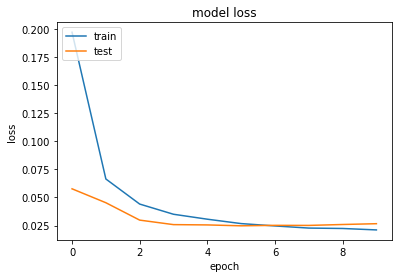

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train","test"],loc="upper left")
plt.show()


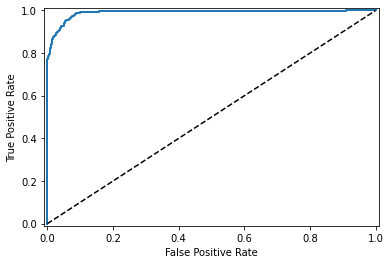

In [0]:
from sklearn.metrics import roc_curve
train_pred = model.predict(np.array(train_x))[:,1]
fpr, tpr, thresholds = roc_curve(train_y, train_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([-0.01,1.01,-0.01,1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

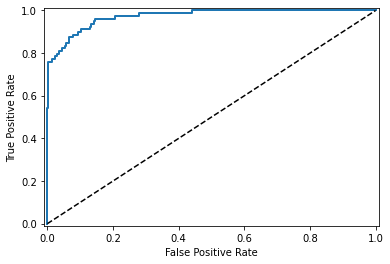

In [0]:
from sklearn.metrics import roc_curve
test_pred = model.predict(np.array(test_x))[:,1]
fpr, tpr, thresholds = roc_curve(test_y, test_pred)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([-0.01,1.01,-0.01,1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test_y, test_pred)

0.9726429152205619

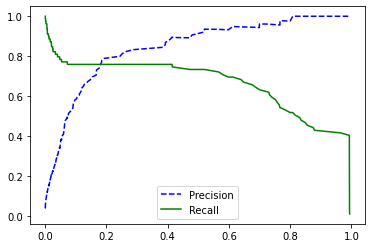

In [0]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(test_y, test_pred)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [0]:
pred = model.predict(np.array(test_x))
pred = np.argmax(pred,axis=1)

print(accuracy_score(test_y, pred),precision_score(test_y, pred), recall_score(test_y, pred),f1_score(test_y, pred),roc_auc_score(test_y,pred))

0.9938725490196079 0.9354838709677419 0.7341772151898734 0.8226950354609929 0.8665887325636945


In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print("threshold, precision_score, recall_score")
for thes in np.arange(0,1,0.05):
    pred = [int(p>thes) for p in test_pred]
    print(thes,precision_score(test_y, pred), recall_score(test_y, pred),roc_auc_score(test_y,pred))

threshold, precision_score, recall_score
0.0 0.019362745098039216 1.0 0.5
0.05 0.4246575342465753 0.7848101265822784 0.8819076876350532
0.1 0.6818181818181818 0.759493670886076 0.8762477102243427
0.15000000000000002 0.8082191780821918 0.7468354430379747 0.8716681589096397
0.2 0.8194444444444444 0.7468354430379747 0.8717931276674502
0.25 0.855072463768116 0.7468354430379747 0.8721680339408818
0.30000000000000004 0.8805970149253731 0.7468354430379747 0.8724179714565029
0.35000000000000003 0.921875 0.7468354430379747 0.8727928777299345
0.4 0.9365079365079365 0.7468354430379747 0.8729178464877451
0.45 0.9365079365079365 0.7468354430379747 0.8729178464877451
0.5 0.9354838709677419 0.7341772151898734 0.8665887325636945
0.55 0.95 0.7215189873417721 0.8603845873974544
0.6000000000000001 0.9655172413793104 0.7088607594936709 0.8541804422312144
0.65 0.9811320754716981 0.6582278481012658 0.8289889552928223
0.7000000000000001 0.98 0.620253164556962 0.8100016135206705
0.75 0.9761904761904762 0.5189

### SVM 决策树 随机森林 xgboost GBDT 

In [0]:
# define model
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC

svm_clf = Pipeline([
("scaler", StandardScaler()),
("linear_svc", LinearSVC(C=1, loss="hinge")),
])


poly_kernel_svm_clf = Pipeline([
("scaler", StandardScaler()),
("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])


rbf_kernel_svm_clf = Pipeline([
("scaler", StandardScaler()),
("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001,probability=True))
])


from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=5)


from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=20, max_leaf_nodes=16,n_jobs=-1)


from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators=20)

from sklearn.ensemble import GradientBoostingClassifier
gbdt_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1.0)

import xgboost
xgb_clf = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=20, silent=True, objective='reg:logistic')

In [0]:
def train_clf(X,y):
    log_reg.fit(X, y)
    # svm_clf.fit(X, y)
    # rbf_kernel_svm_clf.fit(X, y)
    # tree_clf.fit(X, y)
    rnd_clf.fit(X, y)
    ada_clf.fit(X, y)
    xgb_clf.fit(X,y)
    return (log_reg,rnd_clf,ada_clf,xgb_clf)

In [0]:
import joblib #jbolib模块

# joblib.dump(log_reg, path+'model/log_reg.pkl')
# joblib.dump(svm_clf, path+'model/svm_clf.pkl')
# joblib.dump(rbf_kernel_svm_clf, path+'model/rbf_svm_clf.pkl')
# joblib.dump(tree_clf, path+'model/tree_clf.pkl')
# joblib.dump(rnd_clf, path+'model/rnd_clf.pkl')
# joblib.dump(ada_clf, path+'model/ada_clf.pkl')
# joblib.dump(xgb_clf, path+'model/xgb_clf.pkl')


# # #读取Model
log_reg = joblib.load(path+'model/log_reg.pkl')
svm_clf = joblib.load(path+'model/svm_clf.pkl')
rbf_svm_clf = joblib.load(path+'model/rbf_svm_clf.pkl')
tree_clf = joblib.load(path+'model/tree_clf.pkl')
rnd_clf = joblib.load(path+'model/rnd_clf.pkl')
ada_clf = joblib.load(path+'model/ada_clf.pkl')
xgb_clf = joblib.load(path+'model/xgb_clf.pkl')

# nn_clf = keras.models.load_model(path+"model/autoapt_model-0312.h5")

### performance measures

In [0]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict,cross_val_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([-0.01,1.01,-0.01,1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

def model_roc_curve(model,inputs,labels,label):
    pred = model.predict_proba(inputs)[:,1]
    fpr, tpr, thresholds = roc_curve(labels,pred)
    plot_roc_curve(fpr, tpr,label)

In [23]:
t1 = time.time()
fpr, tpr, thresholds = roc_curve(test_y,model.predict(np.array(test_x))[:,1])
time.time()-t1

0.33589816093444824

In [0]:
log_reg,rnd_clf,ada_clf,xgb_clf = train_clf(np.array(train_x),np.array(train_y))

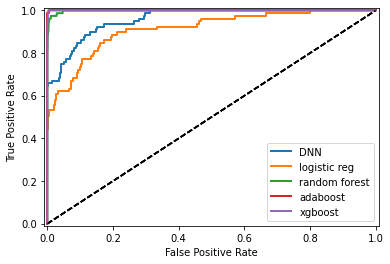

In [26]:
plot_roc_curve(fpr, tpr,"DNN")
model_roc_curve(log_reg,test_x,test_y,"logistic reg")
# model_roc_curve(rbf_svm_clf,test_x,test_y,"rbf_svm")
# model_roc_curve(tree_clf,test_x,test_y,"desision tree")
model_roc_curve(rnd_clf,test_x,test_y,"random forest")
model_roc_curve(ada_clf,test_x,test_y,"adaboost")
model_roc_curve(xgb_clf,test_x,test_y,"xgboost")

plt.legend(loc ="lower right")
# plt.savefig(path+"results/mean-ROC.png")
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_auc_score
print("accuracy_score\t precision_score\t recall_score\t f1_score\t auc\t time")

def performance_score(model,data):
    t0 = time.time()
    pred = model.predict(np.array(data))
    times = time.time()-t0
    print(accuracy_score(test_y, pred),precision_score(test_y, pred), recall_score(test_y, pred),
          f1_score(test_y, pred),roc_auc_score(test_y,pred),times)

# pre = [int(p>=0.5) for p in model.predict(np.array(test_x))]
# print(accuracy_score(test_y, pre),precision_score(test_y, pre), recall_score(test_y, pre),f1_score(test_y, pre),roc_auc_score(test_y,pre))
# performance_score(log_reg,test_x)
# performance_score(svm_clf,test_x)
# performance_score(rnd_clf,test_x)
# performance_score(ada_clf,test_x)
# performance_score(xgb_clf,test_x)

accuracy_score	 precision_score	 recall_score	 f1_score	 auc	 time


数据划分20次，所有模型训练20次，结果取平均

In [0]:
results = {}
all_clf = ['nn','log_reg','rnd_clf','ada_clf','xgb_clf']
metrics = ['pred','precission','recall','f1','auc','time']

from collections import defaultdict
results = {}
for clf in all_clf:
    results[clf]= defaultdict(list)

for i in range(20):
    x, test_x, y,test_y = train_test_split(feature,target, test_size=0.2,random_state=i)
    #划分验证集
    train_x, val_x, train_y,val_y = train_test_split(x,y, test_size=0.1,random_state=1)
    #训练
    model.fit(np.array(train_x),np.array(train_y),epochs = 5,
              validation_data=(np.array(val_x),np.array(val_y)),
              batch_size = 32,verbose=0)

    #ROC(fpr,tpr)
    predict = model.predict(np.array(test_x))[:,1]
    #precision\recall\f1\auc\time
    t0 = time.time()
    pred = model.predict(np.array(test_x))
    dtime = time.time()-t0
    pred = np.argmax(pred,axis=1)
    pre,recall,f1,auc = precision_score(test_y, pred), recall_score(test_y, pred),f1_score(test_y, pred),roc_auc_score(test_y,pred)

    eval = [predict,pre,recall,f1,auc,dtime]
    for metric,eva in zip(metrics,eval):
        results['nn'][metric].append(eva)

    # log_reg,rnd_clf,ada_clf,xgb_clf
    models = train_clf(np.array(train_x),np.array(train_y))
    #存储其他结果
    for clf,clf_model in zip(all_clf[1:],models):
        predict = clf_model.predict_proba(test_x)[:,1]
        t0 = time.time()
        pred = clf_model.predict(np.array(test_x))
        dtime = time.time()-t0
        pre,recall,f1,auc = precision_score(test_y, pred), recall_score(test_y, pred),f1_score(test_y, pred),roc_auc_score(test_y,pred)
        eval = [predict,pre,recall,f1,auc,dtime]
        for metric,eva in zip(metrics,eval):
            results[clf][metric].append(eva)

    print("No. {} training and evaluation".format(i+1))

No. 1 training and evaluation
No. 2 training and evaluation
No. 3 training and evaluation
No. 4 training and evaluation


In [49]:
ada_clf.fit(np.array(train_x),np.array(train_y))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=20, random_state=None)

In [59]:
performance_score(ada_clf,test_x)

0.9958333333333333 0.9436619718309859 0.8375 0.8874172185430463 0.91825 1.1353986263275146


In [58]:
for clf in all_clf:
    for metric in metrics[2:]:
        print(clf,metric,np.mean(results[clf][metric]))

nn precission 0.9794858037111558
nn recall 0.7639807365329199
nn f1 0.8580986441434032
nn auc 0.8818151240232472
nn time 0.355022668838501
log_reg precission 0.7932880416704171
log_reg recall 0.6034399856101312
log_reg f1 0.68462013918093
log_reg auc 0.8000431584540257
log_reg time 0.0861161231994629
rnd_clf precission 0.9831834564175909
rnd_clf recall 0.9459357348897228
rnd_clf f1 0.9640195553410991
rnd_clf auc 0.972792616997137
rnd_clf time 0.24132843017578126
xgb_clf precission 0.9809596037765053
xgb_clf recall 0.8121925794096055
xgb_clf f1 0.8875942456538148
xgb_clf auc 0.9059210642821036
xgb_clf time 0.2541662693023682


## testing

In [0]:
# port_model.wv.vocab

In [0]:
test_set = dataloader.load_data(path+"data/1-inside-labeled.csv")
process_test = dataloader.feature_select(dataloader.processing_data(test_set))
# dataset,labels = dataloader.embedding_mat(process_data,pro_model,port_model,ip_model)

In [0]:
test_s1 = process_test[process_test.stage == 1]
history_ix = np.random.choice(test_s1.index,50)
history,_ = dataloader.embedding_mat(process_test.loc[history_ix],pro_model,port_model,ip_model)
history = np.array(history.tolist())

In [0]:
print(test_s1.index,process_test.shape,process_test[process_test.stage == 2].index[0],process_test[process_test.stage == 5].index[0])

Int64Index([154891, 154892, 154910, 154911, 155029, 155030, 155224, 155225,
            155475, 155476, 155522, 155523, 155553, 155554, 155614, 155615,
            155645, 155646, 155647, 155648, 155692, 155693, 155699, 155700,
            155941, 155942, 155959, 155961, 155999, 156000, 156074, 156075,
            156082, 156083, 156147, 156148, 156211, 156212, 156240, 156241],
           dtype='int64') (646703, 16) 186631 399236


In [0]:
risk,proba = [],[]
count,memory = 1,50
start = time.time()
for i in range(180000,400000):
    new,_ = dataloader.embedding_mat(process_test.take([i]),pro_model,port_model,ip_model)
    # old_history = history
    # history = np.array(history)/(count/count-1)
    inputs = (history*new.tolist()).flatten()
    prob = model.predict(inputs.reshape(1,-1))[0][0]
    if prob >= 0.5 and len(risk)<memory:
        risk.append(new.tolist())
    if len(risk) >= memory:
        # count += 1
        # ix = np.random.randint(0,memory,50)
        # inp = [risk[i] for i in ix]
        history = np.array(history)+np.vstack(risk)
        # new_history = np.vstack(risk)
        # history = np.vstack(risk)
        risk = [] 
        # risk = risk[memory//2:]
    proba.append(np.round(prob,2))
    if i%5000 == 0:
        print(i,time.time()-start)

180000 0.15279769897460938
185000 89.50110673904419
190000 177.44960713386536
195000 267.962411403656
200000 358.21092677116394
205000 447.2537770271301
210000 535.3632197380066
215000 624.739824295044
220000 711.5155313014984
225000 795.4944338798523
230000 877.3442885875702
235000 959.4191579818726
240000 1042.092536687851
245000 1124.0509886741638
250000 1205.8995633125305
255000 1288.7520430088043
260000 1371.909628868103
265000 1453.5274634361267
270000 1534.9909296035767
275000 1616.3879039287567
280000 1700.2128143310547
285000 1789.0048110485077
290000 1877.3283112049103
295000 1963.1592741012573
300000 2050.997756958008
305000 2140.1188781261444
310000 2228.0969347953796
315000 2313.6054260730743
320000 2398.696882009506
325000 2483.3923263549805
330000 2566.8064720630646
335000 2648.932074069977
340000 2730.596914291382
345000 2812.246621608734
350000 2894.344540119171
355000 2976.1835975646973
360000 3058.0806250572205
365000 3141.1123554706573
370000 3223.038467168808
37500

In [0]:
# with open(path+"results/pre_inside_0.6.pickle",'wb') as f:
#     pickle.dump(proba,f)
# with open(path+"results/pre_inside.pickle",'rb') as f:
#     proba_7 = pickle.load(f)

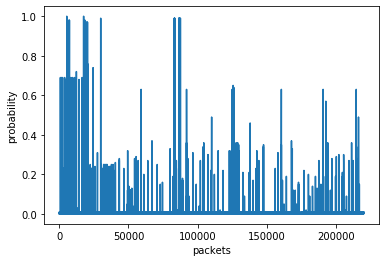

In [0]:
plt.plot(range(len(proba)),proba)
# plt.plot(range(180000,400000),[int(p>0.5) for p in proba],'r')
# plt.plot(range(180000,400000),process_test.stage[180000:400000]/5)
plt.ylabel("probability")
plt.xlabel("packets")
# plt.savefig(path+"results/inside-all-0312-0.6.png")
plt.show()

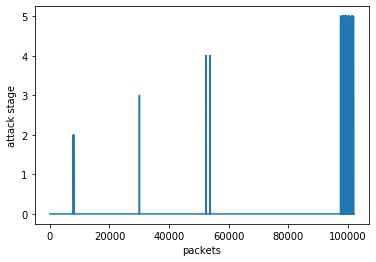

In [0]:
plt.plot(range(len(proba)),process_test.stage[30000:30000+len(proba)])
plt.ylabel("attack stage")
plt.xlabel("packets")
# plt.savefig(path+"results/raw-inside-0312.png")
plt.show()

In [0]:
# port_model.wv.vocab

## attention 

In [0]:
# 设置随机种子，方便复现
seed = 1234
random.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)


class Attention(keras.layers.Layer):
    def __init__(self, attention_hidden_units=(80, 40, 1), attention_activation="sigmoid", supports_masking=True):
        super(Attention, self).__init__()
        self.attention_hidden_units = attention_hidden_units
        self.attention_activation = attention_activation
        self.supports_masking = supports_masking

    def build(self, input_shape):
        super(Attention, self).build(input_shape)

    def call(self, x, mask=None):
        '''
        i_emb:     [Batch_size, Hidden_units]
        hist_emb:        [Batch_size, max_len, Hidden_units]
        hist_len: [Batch_size]
        '''
        assert len(x) == 3

        i_emb, hist_emb, hist_len = x[0], x[1], x[2]
        hidden_units = K.int_shape(hist_emb)[-1]
        max_len = tf.shape(hist_emb)[1]

        i_emb = tf.tile(i_emb, [1, max_len])  # (batch_size, max_len * hidden_units)
        i_emb = tf.reshape(i_emb, [-1, max_len, hidden_units])  # (batch_size, max_len, hidden_units)
        concat = K.concatenate([i_emb, hist_emb, i_emb - hist_emb, i_emb * hist_emb],
                               axis=2)  # (batch_size, max_len, hidden_units * 4)

        for i in range(len(self.attention_hidden_units)):
            activation = None if i == 2 else self.attention_activation
            outputs = keras.layers.Dense(self.attention_hidden_units[i], activation=activation)(concat)
            concat = outputs

        outputs = tf.reshape(outputs, [-1, 1, max_len])  # (batch_size, 1, max_len)

        if self.supports_masking:
            mask = tf.sequence_mask(hist_len, max_len)  # (batch_size, 1, max_len)
            padding = tf.ones_like(outputs) * (-1e12)  
            outputs = tf.where(mask, outputs, padding)

        # 对outputs进行scale
        outputs = outputs / (hidden_units ** 0.5)
        outputs = tf.nn.softmax(outputs)  


        outputs = tf.matmul(outputs, hist_emb)  # batch_size, 1, hidden_units)

        outputs = tf.squeeze(outputs)  # (batch_size, hidden_units)

        return outputs

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], input_shape[0][-1])



def din(item_count, cate_count, hidden_units=128):
    '''
    :param item_count: 商品数
    :param cate_count: 类别数
    :param hidden_units: 隐藏单元数
    :return: model
    '''
    target_item = keras.layers.Input(shape=(1,), name='target_item', dtype="int32")  # 点击的item
    target_cate = keras.layers.Input(shape=(1,), name='target_cate', dtype="int32")  # 点击的item对应的所属类别
    label = keras.layers.Input(shape=(1,), name='label', dtype="float32")  # 是否点击

    hist_item_seq = keras.layers.Input(shape=(None,), name="hist_item_seq", dtype="int32")  # 点击序列
    hist_cate_seq = keras.layers.Input(shape=(None,), name="hist_cate_seq", dtype="int32")  # 点击序列对应的类别序列

    hist_len = keras.layers.Input(shape=(1,), name='hist_len', dtype="int32")  # 序列本来的长度

    item_emb = keras.layers.Embedding(input_dim=item_count,
                                      output_dim=hidden_units // 2,
                                      embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=1e-4,
                                                                                             seed=seed))
    cate_emb = keras.layers.Embedding(input_dim=cate_count,
                                      output_dim=hidden_units // 2,
                                      embeddings_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=1e-4,
                                                                                             seed=seed))
    item_b = keras.layers.Embedding(input_dim=item_count, output_dim=1,
                                    embeddings_initializer=keras.initializers.Constant(0.0))

    # get target bias embedding
    target_item_bias_emb = item_b(target_item)  # (batch_size, 1, 1)
    #
    target_item_bias_emb = keras.layers.Lambda(lambda x: K.squeeze(x, axis=1))(target_item_bias_emb)

    # get target embedding
    target_item_emb = item_emb(target_item)  # (batch_size, 1, hidden_units//2)
    target_cate_emb = cate_emb(target_cate)  # (batch_size, 1, hidden_units//2)
    i_emb = keras.layers.Lambda(lambda x: K.concatenate([x[0], x[1]], axis=-1))(
        [target_item_emb, target_cate_emb])  # (batch_size, 1, hidden_units)
    i_emb = keras.layers.Lambda(lambda x: K.squeeze(x, axis=1))(i_emb)  # (batch_size, hidden_units)

    # get history item embedding
    hist_item_emb = item_emb(hist_item_seq)  # (batch_size, max_len, hidden_units//2)
    hist_cate_emb = cate_emb(hist_cate_seq)  # (batch_size, max_len, hidden_units//2)
    hist_emb = keras.layers.Lambda(lambda x: K.concatenate([x[0], x[1]], axis=-1))(
        [hist_item_emb, hist_cate_emb])  # (batch_size, max_len, hidden_units)

    # 构建点击序列与候选的attention关系
    din_attention = Attention()([i_emb, hist_emb, hist_len])  # (batch_size, hidden_units)
    din_attention = keras.layers.Lambda(lambda x: tf.reshape(x, [-1, hidden_units]))(din_attention)

    # keras.layers.BatchNormalization实现暂时有坑，借用paddle相关代码实现
    din_attention_fc = keras.layers.Dense(63802)(din_attention)  # (batch_size, item_count + cate_count)
    # item_count:  63001   cate_count:  801         hidden_units:  128   (batch_size, item_count + cate_count + hidden_units)
    din_item = keras.layers.Lambda(lambda x: K.concatenate([x[0], x[1]], axis=1))([i_emb, din_attention_fc])
    din_item = share_weights()(din_item)  # (batch_size, 1)

    print("logits:", din_item, target_item_bias_emb)
    logits = keras.layers.Add()([din_item, target_item_bias_emb])

    label_model = keras.models.Model(inputs=[hist_item_seq, hist_cate_seq, target_item, target_cate, hist_len], outputs=[logits])

    train_model = keras.models.Model(inputs=[hist_item_seq, hist_cate_seq, target_item, target_cate, hist_len, label],
                               outputs=logits)

    # 计算损失函数
    loss = K.binary_crossentropy(target=label, output=logits, from_logits=True)
    train_model.add_loss(loss)
    train_model.compile(optimizer=keras.optimizers.SGD(1e-3), metrics=["accuracy"])

    return train_model, label_model